# Library

In [1]:
!pip install -q tensorflowjs ai-edge-litert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 whi

In [2]:
import os, cv2, random, matplotlib.pyplot as plt, warnings, numpy as np, seaborn as sns, tensorflow as tf, pickle, tensorflowjs as tfjs

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

from ai_edge_litert.interpreter import Interpreter

2025-05-24 17:05:44.618171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748106344.820601      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748106344.877425      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Suppress Warnings & TensorFlow Logs

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

warnings.filterwarnings('ignore', category = UserWarning)

tf.get_logger().setLevel('ERROR')

# Directories

In [4]:
TRAIN_DIR = '/kaggle/input/malaria/Malaria Dataset/train'
VALID_DIR = '/kaggle/input/malaria/Malaria Dataset/valid'
TEST_DIR = '/kaggle/input/malaria/Malaria Dataset/test'

OUT_DIR = '/kaggle/working/exported_models'
os.makedirs(OUT_DIR, exist_ok = True)

SAVED_MODEL_DIR = f'{OUT_DIR}/saved_model'
os.makedirs(SAVED_MODEL_DIR, exist_ok = True)

TFJS_MODEL_DIR = f'{OUT_DIR}/tfjs_model'
os.makedirs(TFJS_MODEL_DIR, exist_ok = True)

# Params

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_CNN = 50
EPOCHS_EFFNET = 50

# Data Generators

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle = False
)

Found 13152 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


# Callbacks

In [7]:
early_stop = EarlyStopping(
    monitor = 'accuracy', baseline = 0.95, patience = 0, restore_best_weights = True, mode = 'max', verbose = 1
)

checkpoint = ModelCheckpoint(
    f'{OUT_DIR}/best_model.keras', monitor = 'val_loss', save_best_only = True, verbose = 1
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.1, patience = 3, min_lr = 1e-7, verbose = 1
)

CALLBACKS = [early_stop, checkpoint, reduce_lr]

# Model Builders

In [8]:
def build_custom_cnn(input_shape):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), padding = 'same', input_shape = input_shape),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), padding = 'same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), padding = 'same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Classification
        Flatten(),
        Dense(128, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(
        optimizer = Adam(0.001),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )

    model.summary()
    
    return model

def build_effnetb0(input_shape = (224,224,3), trainable = False):
    base = EfficientNetB0(
        include_top = False, weights = 'imagenet', input_shape = input_shape
    )
    
    base.trainable = trainable
    
    inputs = Input(shape = input_shape)
    
    x = base(inputs, training = False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer = Adam(0.001),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )

    model.summary()
    
    return model

# Plotting & Evaluation

In [9]:
def plot_history(history, title = None):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label = 'Train Acc')
    
    if val_acc:
        plt.plot(epochs, val_acc, label = 'Val Acc')
    
    plt.title(f'{title} Accuracy' if title else 'Accuracy')
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, loss, label='Train Loss')
    
    if val_loss:
        plt.plot(epochs, val_loss, label = 'Val Loss')
    
    plt.title(f'{title} Loss' if title else 'Loss')
    plt.legend(); plt.show()
    
def evaluate_model(model, data, is_generator = True):
    if is_generator:
        y_true = data.classes
        
        data.reset()
        
        y_pred_prob = model.predict(data)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        y_true = []
        y_pred_prob = []
        
        for x_batch, y_batch in data:
            y_true.extend(y_batch.numpy().astype(int).tolist())
            
            preds = model.predict(x_batch)
            
            y_pred_prob.extend(preds.flatten().tolist())
        
        y_true = np.array(y_true)
        y_pred_prob = np.array(y_pred_prob)
        y_pred = (y_pred_prob > 0.5).astype(int)

    print(classification_report(y_true, y_pred, target_names = ['Parasitized','Uninfected']))
    print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
    print('ROC AUC:', roc_auc_score(y_true, y_pred_prob))

# Training Pipeline

## Custom CNN

=== Training Custom CNN ===


I0000 00:00:1748106370.076210      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748106370.076912      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,937,985 (49.35 MB)

 Trainable params: 12,937,985 (49.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1748106374.706284      89 service.cc:148] XLA service 0x7e29540052f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748106374.707458      89 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748106374.707479      89 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748106375.078801      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/411 ━━━━━━━━━━━━━━━━━━━━ 54:44 8s/step - accuracy: 0.5000 - loss: 0.6992

I0000 00:00:1748106380.083015      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5041 - loss: 0.7019
Epoch 1: val_loss improved from inf to 0.69170, saving model to /kaggle/working/exported_models/best_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 143s 330ms/step - accuracy: 0.5041 - loss: 0.7019 - val_accuracy: 0.5088 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5281 - loss: 0.6918
Epoch 2: val_loss improved from 0.69170 to 0.68659, saving model to /kaggle/working/exported_models/best_model.keras
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 152ms/step - accuracy: 0.5281 - loss: 0.6918 - val_accuracy: 0.5377 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5313 - loss: 0.6912
Epoch 3: val_loss did not improve from 0.68659
411/411 ━━━━━━━━━━━━━━━━━━━━ 62s 150ms/step - accuracy: 0.5313 - loss: 0.6912 - val_accuracy: 0.5112 - val_loss: 0.7087 - learning_rate: 0.0010
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━

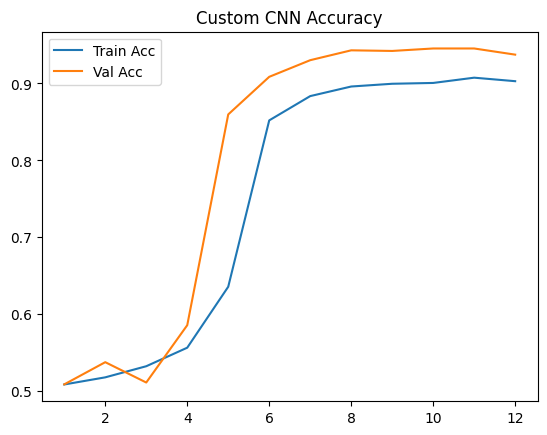

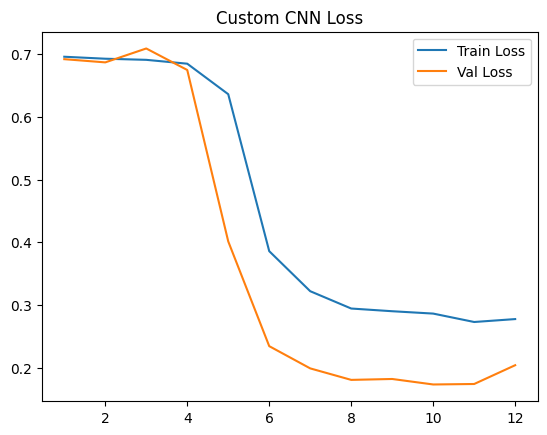

In [10]:
print('=== Training Custom CNN ===')

custom_model = build_custom_cnn(input_shape = (*IMG_SIZE,1))

history_cust = custom_model.fit(
    train_generator, steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = valid_generator, validation_steps = valid_generator.samples // valid_generator.batch_size,
    epochs = EPOCHS_CNN, callbacks = CALLBACKS
)

plot_history(history_cust, title = 'Custom CNN')

In [11]:
evaluate_model(custom_model, test_generator, is_generator = True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step
              precision    recall  f1-score   support

 Parasitized       0.95      0.94      0.94       309
  Uninfected       0.94      0.96      0.95       317

    accuracy                           0.95       626
   macro avg       0.95      0.95      0.95       626
weighted avg       0.95      0.95      0.95       626

Confusion Matrix:
 [[289  20]
 [ 14 303]]
ROC AUC: 0.9811236000939225


In [12]:
custom_model.save(f'{OUT_DIR}/malaria.keras')

## Transfer Learning (EfficientNetB0)

In [13]:
def augment(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.random_brightness(images, max_delta = 0.1)
    images = tf.image.random_contrast(images, lower = 0.9, upper = 1.1)
    
    return images, labels

raw_train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels = 'inferred',
    label_mode = 'binary',
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True
)
class_names = raw_train_ds.class_names

train_dataset = raw_train_ds \
    .map(augment, num_parallel_calls = tf.data.AUTOTUNE) \
    .shuffle(1000) \
    .cache() \
    .prefetch(tf.data.AUTOTUNE)

raw_valid_ds = image_dataset_from_directory(
    VALID_DIR,
    labels = 'inferred',
    label_mode = 'binary',
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)
valid_dataset = raw_valid_ds.cache().prefetch(tf.data.AUTOTUNE)

raw_test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels = 'inferred',
    label_mode = 'binary',
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)
test_dataset = raw_test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 13152 files belonging to 2 classes.
Found 1253 files belonging to 2 classes.
Found 626 files belonging to 2 classes.



=== Training Custom EfficientNetB0 ===
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8864 - loss: 0.2912
Epoch 1: val_loss did not improve from 0.17351
411/411 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.8864 - loss: 0.2911 - val_accuracy: 0.9130 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9148 - loss: 0.2128
Epoch 2: val_loss did not improve from 0.17351
411/411 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9148 - loss: 0.2128 - val_accuracy: 0.9306 - val_loss: 0.1787 - learning_rate: 0.0010
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9228 - loss: 0.2020
Epoch 3: val_loss did not improve from 0.17351
411/411 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9228 - loss: 0.2020 - val_accuracy: 0.9338 - val_loss: 0.1743 - learning_rate: 0.0010
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9269 - loss: 0.1888
Epoch 4: val_loss improved from 0.17351 to 0.16970, saving model to /kaggle/workin

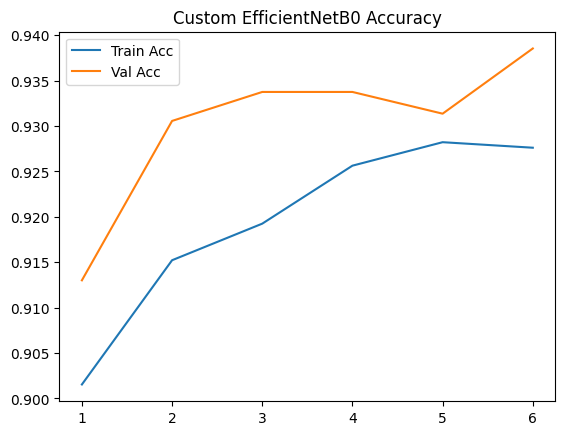

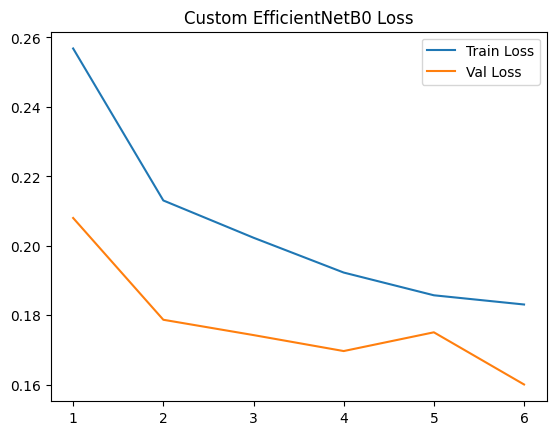

In [14]:
print('\n=== Training Custom EfficientNetB0 ===')

eff_model = build_effnetb0(input_shape = (*IMG_SIZE,3), trainable = False)

history_eff = eff_model.fit(
    train_dataset, validation_data = valid_dataset,
    epochs = EPOCHS_EFFNET, callbacks = CALLBACKS
)

plot_history(history_eff, title = 'Custom EfficientNetB0')

In [15]:
evaluate_model(eff_model, test_dataset, is_generator = False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
              precision    recall  f1-score   support

 Parasitized       0.97      0.88      0.93       309
  Uninfected       0.90      0.97      0.93       317

    accuracy                           0.93       626
   macro avg       0.93  

In [16]:
eff_model.save(f'{OUT_DIR}/malaria_effnetb0.keras')

# Plotting Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


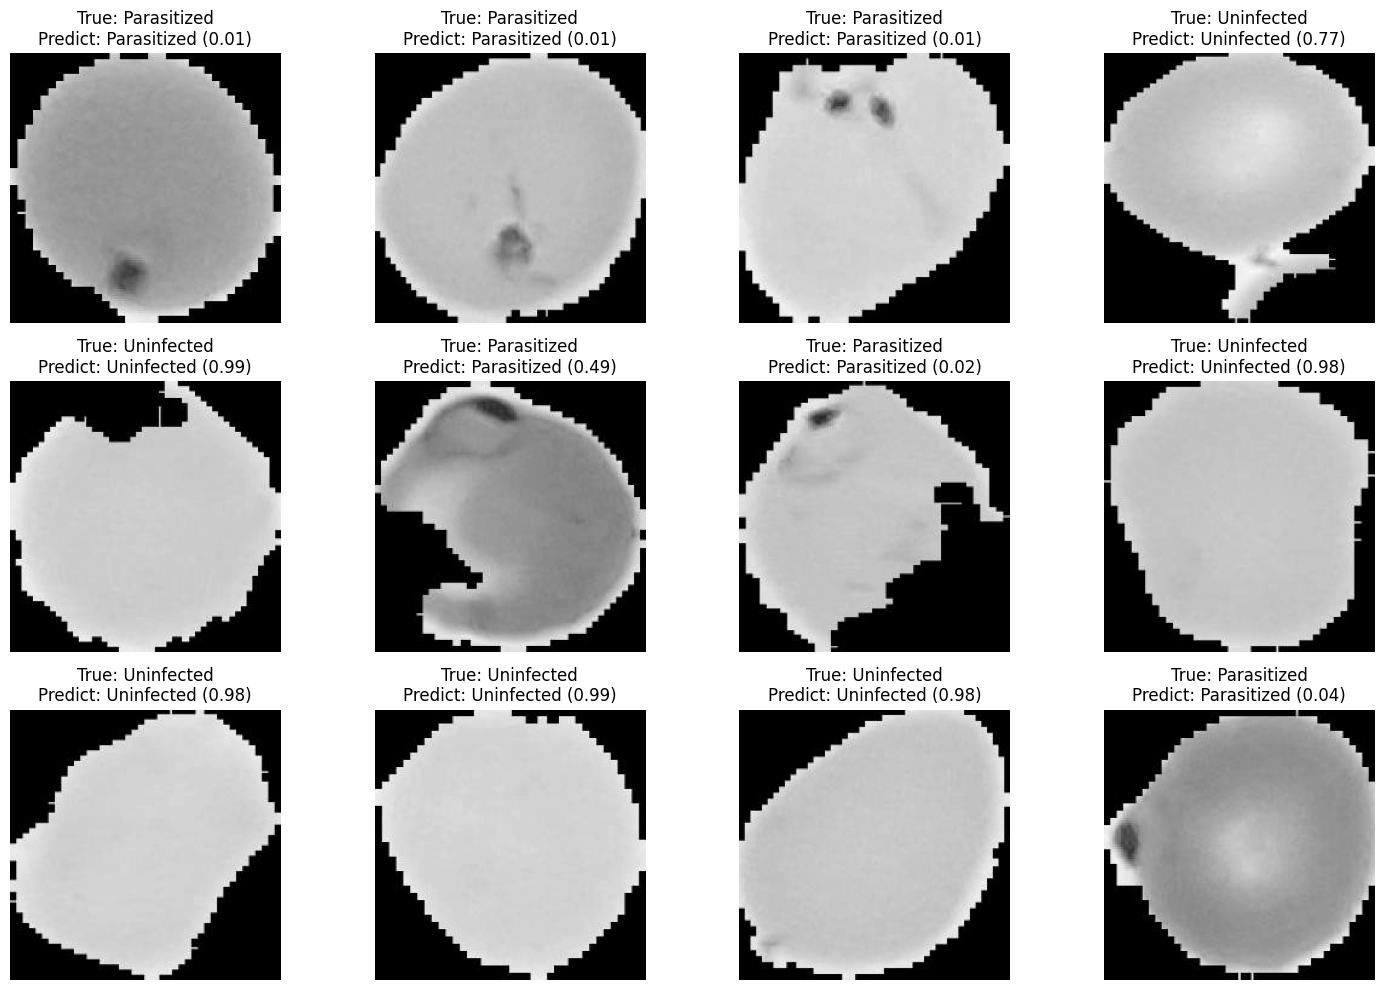

In [17]:
file_paths = np.array(test_generator.filepaths)
labels = np.array(test_generator.classes)
class_names = list(test_generator.class_indices.keys())

samples_per_class = 6
selected_idxs = []

for cls in np.unique(labels):
    cls_idxs = np.where(labels == cls)[0]
    
    selected_idxs.extend(random.sample(list(cls_idxs), samples_per_class))
    
random.shuffle(selected_idxs)

plt.figure(figsize = (15, 10))

for i, idx in enumerate(selected_idxs):
    path = file_paths[idx]
    # Read as grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img_input = img.astype('float32') / 255.0
    img_input = np.expand_dims(img_input, axis = (0, -1))

    # Predict with Custom CNN
    prob = custom_model.predict(img_input)[0,0]
    pred_label = class_names[int(prob > 0.5)]
    true_label = class_names[labels[idx]]

    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredict: {pred_label} ({prob:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


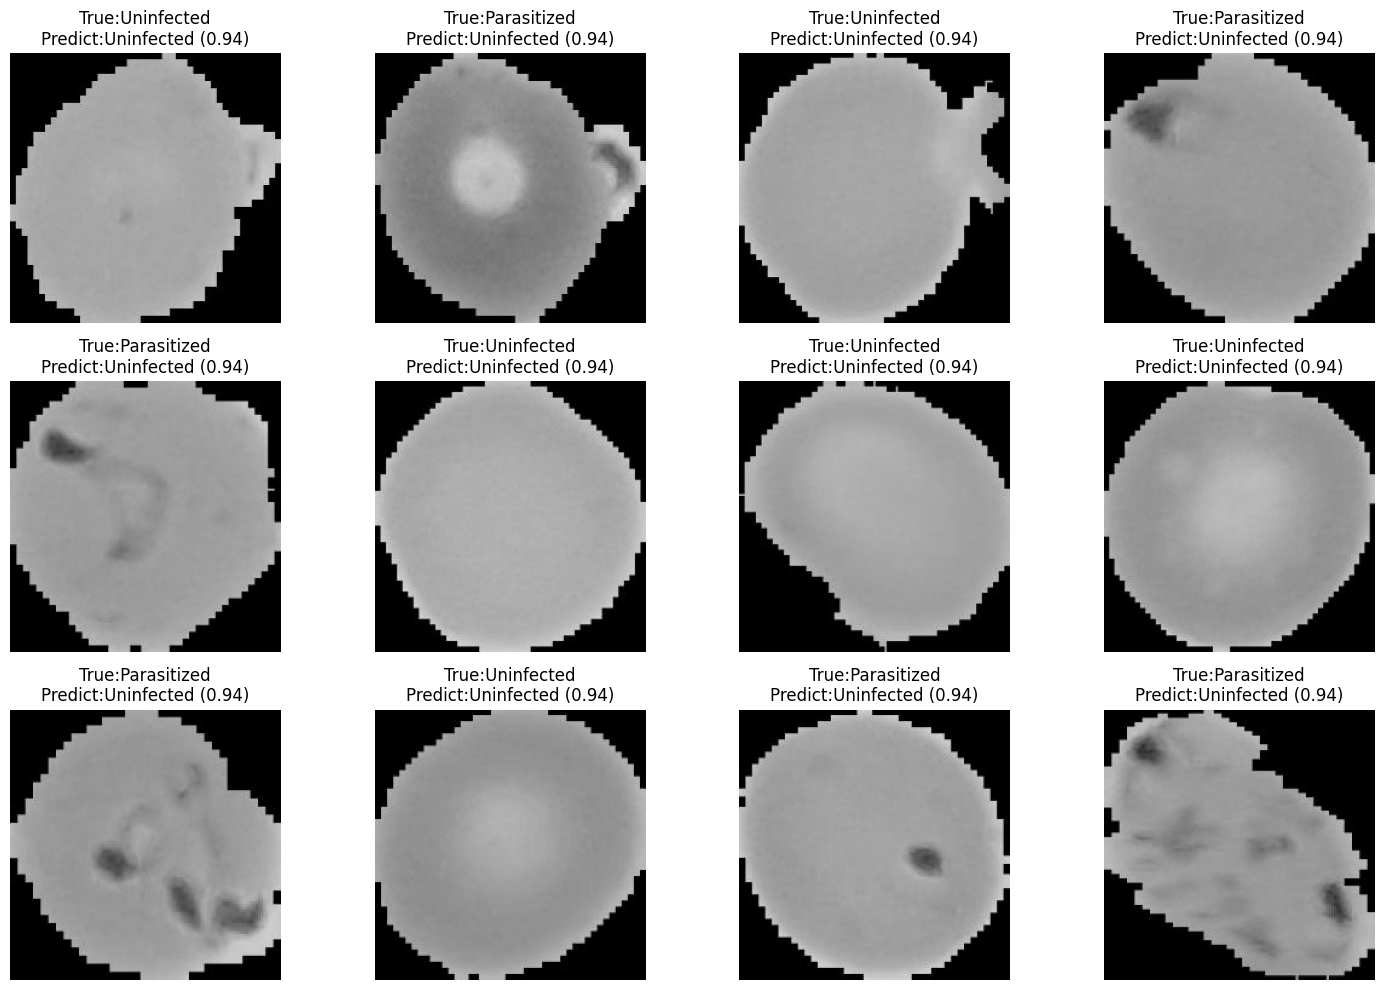

In [18]:
file_paths = np.array(test_generator.filepaths)
labels = np.array(test_generator.classes)

samples_per_class = 6
selected_idxs = []

for cls in np.unique(labels):
    cls_idxs = np.where(labels == cls)[0]
    
    selected_idxs.extend(random.sample(list(cls_idxs), samples_per_class))

random.shuffle(selected_idxs)

plt.figure(figsize = (15, 10))

for i, idx in enumerate(selected_idxs):
    # Read as RGB
    path = file_paths[idx]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # Predict with EfficientNetB0
    true_label = class_names[labels[idx]]
    prob = eff_model.predict(np.expand_dims(img.astype('float32') / 255.0, axis = 0))[0,0]
    pred_label = class_names[int(prob > 0.5)]
    
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"True:{true_label}\nPredict:{pred_label} ({prob:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Export Model

## SavedModel

In [19]:
custom_model.export(f'{SAVED_MODEL_DIR}/custom_model')
eff_model.export(f'{SAVED_MODEL_DIR}/EfficientNetB0_model')

Saved artifact at '/kaggle/working/exported_models/saved_model/custom_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138719491198992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491201488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491200720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491199952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491201296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491202640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491200144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491204176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491204752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138719491201680: TensorSpec(shape=(), dtype=

## Pickle

In [20]:
with open(f'{OUT_DIR}/Malaria.pkl', 'wb') as f:
    pickle.dump(custom_model, f)

with open(f'{OUT_DIR}/Malaria_EfficientNetB0.pkl', 'wb') as f:
    pickle.dump(eff_model, f)

## TF Lite

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(f'{SAVED_MODEL_DIR}/custom_model')

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

with open(f'{OUT_DIR}/Malaria.tflite', 'wb') as f:
    f.write(tflite_model)

print(os.path.getsize(f'{OUT_DIR}/Malaria.tflite'))

converter_eff = tf.lite.TFLiteConverter.from_saved_model(f'{SAVED_MODEL_DIR}/EfficientNetB0_model')

converter_eff.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model_eff = converter_eff.convert()

with open(f'{OUT_DIR}/Malaria_EfficientNetB0.tflite', 'wb') as f:
    f.write(tflite_model_eff)

print(os.path.getsize(f'{OUT_DIR}/Malaria_EfficientNetB0.tflite'))

W0000 00:00:1748107414.747512      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748107414.747550      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748107414.755565      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


51755916


W0000 00:00:1748107438.523050      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748107438.523079      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


18661180


In [22]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open(f'{OUT_DIR}/Malaria_quant.tflite', 'wb') as f:
    f.write(tflite_model)

print(os.path.getsize(f'{OUT_DIR}/Malaria_quant.tflite'))

converter_eff.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_eff = converter_eff.convert()

with open(f'{OUT_DIR}/Malaria_EfficientNetB0_quant.tflite', 'wb') as f:
    f.write(tflite_model_eff)

print(os.path.getsize(f'{OUT_DIR}/Malaria_EfficientNetB0_quant.tflite'))

W0000 00:00:1748107443.522372      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748107443.522400      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


12948120


W0000 00:00:1748107458.718079      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748107458.718109      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


5212784


## TF JS

In [23]:
tfjs.converters.convert_tf_saved_model(
    f'{SAVED_MODEL_DIR}/custom_model',
    f'{TFJS_MODEL_DIR}/custom_model',
    saved_model_tags = 'serve'
)

print(f'{TFJS_MODEL_DIR}/custom_model')

tfjs.converters.convert_tf_saved_model(
    f'{SAVED_MODEL_DIR}/EfficientNetB0_model',
    f'{TFJS_MODEL_DIR}/EfficientNetB0_model',
    saved_model_tags = 'serve'
)

print(f'{TFJS_MODEL_DIR}/EfficientNetB0_model')

I0000 00:00:1748107463.679317      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1748107463.679462      19 single_machine.cc:361] Starting new session
I0000 00:00:1748107463.681540      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748107463.681740      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


/kaggle/working/exported_models/tfjs_model/custom_model


I0000 00:00:1748107480.410369      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1748107480.410540      19 single_machine.cc:361] Starting new session
I0000 00:00:1748107480.412615      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748107480.412850      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


/kaggle/working/exported_models/tfjs_model/EfficientNetB0_model


# Remove Outputs

In [24]:
# !rm -r /kaggle/working/*